# BBM409 : Introduction to Machine Learning Lab. Assignment 1

In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'c:\users\berkay\desktop\workspace\bbm409\assig_1\venv\scripts\python.exe -m pip install --upgrade pip' command.


## Imports

In [2]:
from math import sqrt
import numpy as np
from tqdm import tqdm
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

### Graph Drawer Method

In [4]:
def plot_k_values_and_accuracies(title1, title2, arr1, arr2, fontSize, isAcc=True):
    x = np.array(["1", "3", "5", "7", "9"])
    plt.subplot(1, 2, 1)
    plt.subplots_adjust(wspace=0.4)
    plt.plot(x, arr1, marker='o')

    plt.title(title1, fontdict=fontSize)
    plt.xlabel("K values")

    plt.ylabel("Accuracies" if isAcc else "Mean MAE")

    plt.subplot(1, 2, 2)
    plt.plot(x, arr2, marker='o')

    plt.title(title2, fontdict=fontSize)
    plt.xlabel("K values")
    plt.ylabel("Accuracies" if isAcc else "Mean MAE")

    plt.show()

### Euclidean Distance Method

In [5]:
def euclidean_distance(first_row, second_row):
    if len(first_row) != len(second_row):
        raise Exception("Two rows must have the same dimension!")

    total = 0
    for index in range(len(first_row)):
        diff_square = (first_row[index] - second_row[index]) ** 2
        total += diff_square
    return sqrt(total)

### Accuracy Calculator Method

In [6]:
def accuracy_score(predicted, labels):
    predicted = np.array(predicted)
    labels = np.array(labels)

    # Comparison between predictions and the test labels.
    accuracy = (predicted == labels).sum() / len(predicted)
    # print(accuracy*100)
    return accuracy * 100

### Mean Absolute Error Calculator Method

In [7]:
def mean_absolute_error(predicted, labels):
    predicted = np.array(predicted)
    labels = np.array(labels)


    mae = np.absolute(labels - predicted).sum() / len(predicted)
    return mae

### Min-Max Normalization Method

In [8]:
def min_max_normalization(data):
    # max_bucket = [-1000000000 for i in range(len(data[0]))]

    # working on temp data
    temp_data = data.copy()

    length = len(temp_data[0])

    # scaling each attribute of the data
    for i in range(length):
        col_data = temp_data[:, i]
        _max = np.max(col_data)
        _min = np.min(col_data)

        # applying min-max normalization
        col_data = (col_data - _min) / (_max - _min)

        # replace data
        temp_data[:, i] = col_data

    return temp_data


### k-fold Cross Validation Splitter Method

In [9]:
def k_fold_cross_validation_split(X, k=5):
    # takes numpy array as an argument
    # shuffle
    np.random.shuffle(X)

    splitted_data = []
    data_partition_num = len(X) / k

    for i in range(k):
        start = int(i * data_partition_num)
        end = int((i + 1) * data_partition_num)

        test_set = X[start:end, :]
        train_set = np.concatenate((X[0:start, :], X[end:, :]), axis=0)

        splitted_data.append(np.array([train_set, test_set], dtype=object))

    return np.array(splitted_data)


### Method That Performs Cross Validation(runs all possible train set combinations)

In [10]:
def cross_validation(splitted_data, knn, normalize, classification):
    accuracies = []
    mae_values = []

    for data in splitted_data:
        sample_train = data[0]
        sample_test = data[1]

        # print(sample_train.shape)
        # print(sample_test.shape)

        # train and test sets
        X_train = sample_train[:, :-1]
        y_train = sample_train[:, -1]

        X_test = sample_test[:, :-1]
        y_test = sample_test[:, -1]

        if normalize:
            """
                Applying min-max normalization to data

                Applying separately to avoid data leakage
            """
            X_train = min_max_normalization(X_train)
            X_test = min_max_normalization(X_test)

        # fitting data
        knn.fit(X_train, y_train)

        # prediction part
        predictions = knn.predict(X_test)

        # print(knn.y_train)
        # print(predictions)
        # print(y_test)

        if classification:
            # calculate accuracy
            accuracy = accuracy_score(predictions, y_test)
            accuracies.append(accuracy)
        else:
            mae = mean_absolute_error(predictions, y_test)
            mae_values.append(mae)

    if classification:
        accuracies = np.array(accuracies)
        return np.sort(accuracies), np.mean(accuracies)
    else:
        return np.sort(mae_values), np.mean(mae_values)


### KNN Base Class

In [11]:
class KnnBase:

    # setting k value of KNN algorithm
    def __init__(self, k=3):
        self.k = k

    # setting attribute and class data
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # majority voting function
    def vote(self, neighbours, frequence_array):
        raise NotImplementedError("Each class must implement their own voting function !")

    def predict(self, X):
        predicted_classes = [self.predict_helper(row) for row in X]
        return predicted_classes

    def predict_helper(self, x):
        raise NotImplementedError("Each class must implement their own predict_helper function !")


### KNN Classification Class Without Weight Values

In [12]:
class KNN(KnnBase):

    # setting k value of KNN algorithm
    def __init__(self, k=3):
        super().__init__(k)

    # majority voting function
    def vote(self, neighbours, frequence_array=None):
        distances = []
        classes = []
        indexes = []

        for neighbour in neighbours:
            index = neighbour[1]  # neighbour[1] : index of related data's row
            # recall --> [dist, index_of_neighbour]

            _class = self.y_train[index]  # _ class : corresponding data in the Class set
            _distance = neighbour[0]  # neighbour[0] : distance of related data

            # save all information in various lists
            distances.append(_distance)
            classes.append(_class)
            indexes.append(index)

        # print("-----voting part-----")
        counted = list(Counter(classes).items())  # numerical grouping by class of each data
        # print(classes)
        # print(counted)
        # print("distances: ", distances)

        most_common = counted[0]  # find the most repetitive class
        class_numbers = [i[1] for i in counted]  # store the number of repetitions of classes
        # print(class_numbers)

        if class_numbers.count(most_common[0]) > 1:  # if the most common class has more than one sample

            # x = input("tie found, press any key to continue")

            # that means we have a tie situation..
            classes_of_duplicate_occurrences = []
            for cnt in counted:
                if cnt[1] == most_common[1]:
                    # the one that we are looking for
                    classes_of_duplicate_occurrences.append(
                        cnt[0])  # find the classes of the data that provide the tie situation

            # print(classes_of_duplicate_occurrences)

            # breaking tie part
            new_distances = [[] for i in range(int(max(classes_of_duplicate_occurrences)) + 1)]

            for _class in classes_of_duplicate_occurrences:
                for __index, __class in enumerate(classes):
                    if _class == __class:
                        # access distance of neighbour from the array which is created above
                        indiv_distance = distances[__index]

                        # store distances to calculate sums later and decide nearest neighbour
                        new_distances[int(_class)].append(indiv_distance)

            # print(new_distances)

            empty_list_indices = [i for i in range(len(new_distances)) if len(new_distances[i]) == 0]

            for index, new_distance in enumerate(new_distances):
                new_distances[index] = sum(new_distance)

            new_distances = np.array(new_distances)
            # print(new_distances)

            sorted_indices = np.argsort(new_distances)
            # print(sorted_indices)

            # print("empty part")
            # print(empty_list_indices)

            will_be_deleted_indices = []
            for index in empty_list_indices:
                for i, _index in enumerate(sorted_indices):
                    if index == _index:
                        will_be_deleted_indices.append(i)

            sorted_indices = np.delete(sorted_indices, will_be_deleted_indices)
            # print(sorted_indices)

            predicted_class = int(sorted_indices[0])
            # print(predicted_class)
        else:
            # no tie select most common as nearest neighbour
            predicted_class = int(most_common[0])

        return predicted_class

    def predict_helper(self, x):
        """
        [
            [dist, index_of_neighbour],
            [another_dist, index_of_another_neighbour],
            ...
        ]
        """

        # distance calculation
        distances = [[euclidean_distance(x, self.X_train[i]), i] for i in range(len(self.X_train))]

        # sorting to find nearest neighbour
        # print(distances)
        sorted_array = sorted(distances, key=lambda x: x[0])
        # print(sorted_array)

        # print("Asked data: ", x.astype(int))
        # print("Nearest Neighbours:")
        for m in range(self.k):
            index = sorted_array[m][1]
            # print(self.X_train[index], ", class: " ,self.y_train[index])

        predicted = self.vote(sorted_array[:self.k])
        return predicted

### KNN Classification Class With Weights

In [13]:
class WeightedKNN(KnnBase):

    # setting k value of KNN algorithm
    def __init__(self, k=3):
        super().__init__(k)

    # majority voting function
    def vote(self, neighbours, frequence_array):
        distances = []
        classes = []
        indexes = []
        weights = []

        for neighbour in neighbours:
            _index = neighbour[1]  # neighbour[1] : index of related data's row
            # recall --> [dist, index_of_neighbour]

            _class = self.y_train[_index]  # _ class : corresponding data in the Class set
            _distance = neighbour[0]  # neighbour[0] : distance of related data
            _weight = 1 if _distance == 0 else (1 / _distance)

            # save all information in various lists
            distances.append(_distance)
            classes.append(_class)
            indexes.append(_index)
            weights.append(_weight)

        # just for convention
        counted = frequence_array

        # print("-----voting part-----")

        # old code
        # counted = list(Counter(classes).items())

        # print(classes)
        # print(counted)
        # print("distances: ", distances)

        most_common = counted[0]  # find the most repetitive class
        class_numbers = [i[1] for i in counted]  # store the number of repetitions of classes
        # print(class_numbers)

        if class_numbers.count(most_common[0]) > 1:  # if the most common class has more than one sample

            # x = input("tie found, press any key to continue")

            # that means we have a tie situation
            classes_of_duplicate_occurrences = []
            for cnt in counted:
                if cnt[1] == most_common[1]:
                    # the one that we are looking for
                    classes_of_duplicate_occurrences.append(cnt[0])

            # print(classes_of_duplicate_occurrences)

            # breaking tie part
            new_distances = [[] for i in range(int(max(classes_of_duplicate_occurrences)) + 1)]

            for _class in classes_of_duplicate_occurrences:
                for __index, __class in enumerate(classes):
                    if _class == __class:
                        # access distance of neighbour from the array which is created above
                        indiv_distance = distances[__index]

                        # store distances to calculate sums later and decide nearest neighbour
                        new_distances[int(_class)].append(indiv_distance)

            # print(new_distances)

            empty_list_indices = [i for i in range(len(new_distances)) if len(new_distances[i]) == 0]

            for index, new_distance in enumerate(new_distances):
                new_distances[index] = sum(new_distance)

            new_distances = np.array(new_distances)
            # print(new_distances)

            sorted_indices = np.argsort(new_distances)
            # print(sorted_indices)

            # print("empty part")
            # print(empty_list_indices)

            will_be_deleted_indices = []
            for index in empty_list_indices:
                for i, _index in enumerate(sorted_indices):
                    if index == _index:
                        will_be_deleted_indices.append(i)

            sorted_indices = np.delete(sorted_indices, will_be_deleted_indices)
            # print(sorted_indices)

            predicted_class = int(sorted_indices[0])
            # print(predicted_class)
        else:
            # no tie select most common as nearest neighbour
            predicted_class = int(most_common[0])

        return predicted_class

    def predict_helper(self, x):
        """
        [
            [dist, index_of_neighbour],
            [another_dist, index_of_another_neighbour],
            ...
        ]
        """

        # distance calculation
        distances = [[euclidean_distance(x, self.X_train[i]), i] for i in range(len(self.X_train))]

        # sorting to find nearest neighbour
        # print(distances)
        sorted_array = sorted(distances, key=lambda x: x[0])
        # print(sorted_array)

        # print("Asked data: ", x.astype(int))
        # print("Nearest Neighbours:")
        for m in range(self.k):
            index = sorted_array[m][1]
            # print(self.X_train[index], ", class: " ,self.y_train[index])

        # finding maximum class number to decide weight_dict size
        maximum_class = int(np.max([self.y_train[i[1]] for i in sorted_array[:self.k]]))

        weight_dict = {(i + 1): 0 for i in range(maximum_class + 1)}

        for _tuple in range(self.k):
            neighb_val = self.y_train[sorted_array[_tuple][1]]
            # print(sorted_array[_tuple][0])
            if not sorted_array[_tuple][0] == 0:
                weight_dict[neighb_val] += (1 / sorted_array[_tuple][0])
            else:
                # if distance value equals to 0, weight value becomes 1 to avoid zero division error
                weight_dict[neighb_val] += 1

        # equivalent of Counter() method output from collections which has used on basic KNN
        """
        frequence_array = [
            (class1, weight1), 
            (class2, weight2),
            (..., ...),
            ...
        ]
        """
        frequence_array = [(_class, weight_dict[_class]) for _class in weight_dict.keys()]
        frequence_array = sorted(frequence_array, key=lambda x: x[1], reverse=True)

        # print(frequence_array)

        # print(sorted_array[:self.k])
        predicted = self.vote(sorted_array[:self.k], frequence_array)
        return predicted


### KNN Regression Base Class

In [14]:
class KNNRegressionBase:

    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def regression(self, neighbours):
        raise NotImplementedError("Each class must implement their regression function !")

    def predict(self, X):
        predicted_classes = [self.predict_helper(row) for row in X]
        return predicted_classes

    def predict_helper(self, x):
        """
        [
            [dist, index_of_neighbour],
            [another_dist, index_of_another_neighbour],
            ...
        ]
        """

        # distance calculation
        distances = [[euclidean_distance(x, self.X_train[i]), i] for i in range(len(self.X_train))]

        # sorting to find nearest neighbour
        # print(distances)
        sorted_array = sorted(distances, key=lambda x: x[0])
        # print(sorted_array)

        # print("Asked data: ", x.astype(int))
        # print("Nearest Neighbours:")
        for m in range(self.k):
            index = sorted_array[m][1]
            # print(self.X_train[index], ", class: " ,self.y_train[index])

        predicted = self.regression(sorted_array[:self.k])
        return predicted

### KNN Regression Class Without Weight Values

In [15]:
class KNNRegression(KNNRegressionBase):

    def __init__(self, k=3):
        super().__init__(k)

    def regression(self, neighbours):
        values = [self.y_train[neighbour[1]] for neighbour in neighbours]
        return np.mean(values)


### KNN Regression Class With Weight Values

In [16]:
class WeightedKNNRegression(KNNRegressionBase):

    def __init__(self, k=3):
        super().__init__(k)

    def regression(self, neighbours):
        values = np.array([self.y_train[neighbour[1]] for neighbour in neighbours])
        weights = np.array([(1 / neighbour[0]) if neighbour[0] != 0 else 1 for neighbour in neighbours])

        return ((values * weights).sum()) / weights.sum()


### Test Method That Performs Several Tests Which Are All Possible Scenarios

In [17]:
def generalTest():

    # classification part
    classification_data = pd.read_csv("glass.csv")
    classification_data = np.array(classification_data)

    # 5 fold cross validation
    splitted = k_fold_cross_validation_split(classification_data, 5)

    # regression part
    regression_data = pd.read_csv("Concrete_Data_Yeh.csv")
    regression_data = np.array(regression_data)

    # 5 fold cross validation
    regression_splitted = k_fold_cross_validation_split(regression_data, 5)

    k_list_withWeight = []
    k_list_withoutWeight = []
    k_list_withWeight_nonNormalized = []
    k_list_withoutWeight_nonNormalized = []
    k_list_withWeight_MAE = []
    k_list_withoutWeight_MAE = []
    k_list_withWeight_nonNormalized_MAE = []
    k_list_withoutWeight_nonNormalized_MAE = []
    for i in range(1, 6):
        k_val = (2 * i) - 1

        for bool in [True, False]:
            text = "With" if bool else "Without"
            print("*********************************")
            print(f"{text} Normalization, k={k_val}")

            print("Classification Part")
            knn = KNN(k=k_val)
            knn1 = WeightedKNN(k=k_val)

            accuracies, mean_acc = cross_validation(splitted, knn, normalize=bool, classification=True)
            accuracies1, mean_acc1 = cross_validation(splitted, knn1, normalize=bool, classification=True)
            print("Distance based accuracies: ", accuracies, mean_acc)
            print("Weighted accuracies: ", accuracies1, mean_acc1)

            print("Regression Part")
            knn2 = KNNRegression(k=k_val)
            knn3 = WeightedKNNRegression(k=k_val)

            mae_values, mean_mae = cross_validation(regression_splitted, knn2, normalize=bool, classification=False)
            mae_values1, mean_mae1 = cross_validation(regression_splitted, knn3, normalize=bool,
                                                      classification=False)

            print("Mae values: ", mae_values)
            print("Weighted Mae values: ", mae_values1)

            if bool:
                k_list_withoutWeight.append(mean_acc)
                k_list_withWeight.append(mean_acc1)
                k_list_withoutWeight_MAE.append(mean_mae)
                k_list_withWeight_MAE.append(mean_mae1)
            else:
                k_list_withoutWeight_nonNormalized.append(mean_acc)
                k_list_withWeight_nonNormalized.append(mean_acc1)
                k_list_withoutWeight_nonNormalized_MAE.append(mean_mae)
                k_list_withWeight_nonNormalized_MAE.append(mean_mae1)
    
    # returning relevant arrays for drawing graphs 
    return [
        k_list_withoutWeight, k_list_withWeight, 
        k_list_withoutWeight_nonNormalized, 
        k_list_withWeight_nonNormalized, k_list_withoutWeight_MAE, 
        k_list_withWeight_MAE, k_list_withoutWeight_nonNormalized_MAE,
        k_list_withoutWeight_nonNormalized_MAE
    ]
    
    

In [18]:
def display(k_list_withoutWeight, k_list_withWeight, 
    k_list_withoutWeight_nonNormalized, k_list_withWeight_nonNormalized, 
    k_list_withoutWeight_MAE, k_list_withWeight_MAE, 
    k_list_withoutWeight_nonNormalized_MAE, k_list_withWeight_nonNormalized_MAE):
    
   
    
    # plotting graphs
    plot_k_values_and_accuracies("KNN without weights", "KNN with weights", k_list_withoutWeight, k_list_withWeight,
                                 {'size': 12})
    plot_k_values_and_accuracies("KNN without weights (non normalized)", "KNN with weights (non normalized)",
                                 k_list_withoutWeight_nonNormalized, k_list_withWeight_nonNormalized, {'size': 9})
    plot_k_values_and_accuracies("KNN Regression without weights", "KNN Regression with weights",
                                 k_list_withoutWeight_MAE, k_list_withWeight_MAE, {'size': 10}, isAcc=False)
    plot_k_values_and_accuracies("KNN Regression without weights (non normalized)",
                                 "KNN Regression with weights (non normalized)",
                                 k_list_withoutWeight_nonNormalized_MAE, k_list_withWeight_nonNormalized_MAE,
                                 {'size': 7}, isAcc=False)

### Obtaining Data Needed For Graphs and Running Main Method with General Test Method

In [19]:
 # relevant data
arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8 = generalTest()

*********************************
With Normalization, k=1
Classification Part
Distance based accuracies:  [41.86046512 53.48837209 53.48837209 66.66666667 67.44186047] 56.58914728682171
Weighted accuracies:  [41.86046512 53.48837209 53.48837209 66.66666667 67.44186047] 56.58914728682171
Regression Part
Mae values:  [5.58830097 5.90126214 6.56218447 6.64776699 7.05791262]
Weighted Mae values:  [5.58830097 5.90126214 6.56218447 6.64776699 7.05791262]
*********************************
Without Normalization, k=1
Classification Part
Distance based accuracies:  [69.76744186 69.76744186 72.09302326 72.09302326 73.80952381] 71.50609080841639
Weighted accuracies:  [69.76744186 69.76744186 72.09302326 72.09302326 73.80952381] 71.50609080841639
Regression Part
Mae values:  [5.95140777 6.09762136 6.37626214 6.43432039 6.91830097]
Weighted Mae values:  [5.95140777 6.09762136 6.37626214 6.43432039 6.91830097]
*********************************
With Normalization, k=3
Classification Part
Distance base

### Calling Method Called Display For Graphs

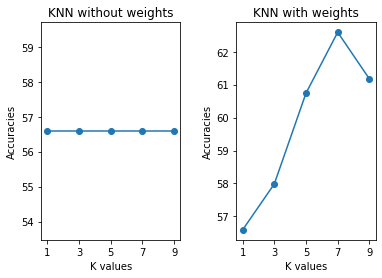

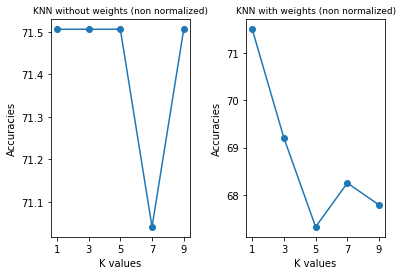

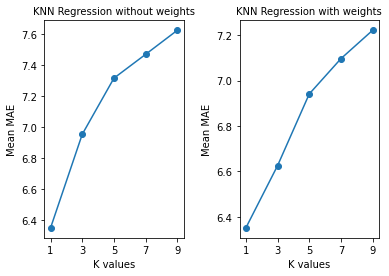

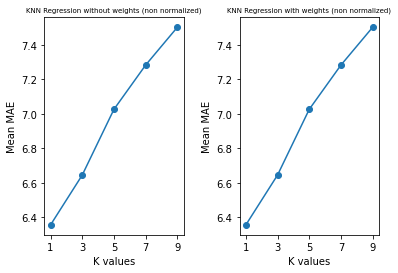

In [20]:
display(arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8)